## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# L1
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# L2
def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
# L1_L2
def build_mlp_l1l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1l2_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8]
L2_EXP = [1e-2, 1e-4, 1e-8]
L1L2_EXP = [1e-2, 1e-4, 1e-8]
results = {}

In [9]:
# L1
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0720 09:17:36.497714  4588 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0720 09:17:36.499708  4588 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 09:17:36.522647  4588 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 09:17:36.524645  4588 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 09:17:36.638337  4588 

Experiment with Regulizer = 0.010000


W0720 09:17:36.800902  4588 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

W0720 09:17:36.994397  4588 deprecation.py:323] From C:\Users\vince\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 101us/step - loss: 360.9187 - acc: 0.1338 - val_loss: 299.2086 - val_acc: 0.1942
Epoch 2/50
50000/50000 [==============================] - 2s 42us/step - loss: 237.6206 - acc: 0.1876 - val_loss: 177.6831 - val_acc: 0.2321
Epoch 3/50
50000/50000 [==============================] - 2s 41us/step - loss: 131.8673 - acc: 0.1964 - val_loss: 90.2170 - val_acc: 0.2165
Epoch 4/50
50000/50000 [==============================] - 2s 42us/step - loss: 62.9816 - acc: 0.1956 - val_loss: 41.0127 - val_acc: 0.2253
Epoch 5/50
50000/50000 [==============================] - 2s 42us/step - loss: 31.7621 - acc: 0.1438 - val_loss: 25.1080 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 20.9594 - acc: 0.0998 - val_loss: 17.1529 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 44us/step - loss: 14.1959 - acc: 0.1007 - val_los

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 53us/step - loss: 6.2914 - acc: 0.1365 - val_loss: 6.1588 - val_acc: 0.2222
Epoch 2/50
50000/50000 [==============================] - 2s 40us/step - loss: 6.1427 - acc: 0.1970 - val_loss: 6.0181 - val_acc: 0.2554
Epoch 3/50
50000/50000 [==============================] - 2s 41us/step - loss: 6.0433 - acc: 0.2316 - val_loss: 5.9330 - val_acc: 0.2829
Epoch 4/50
50000/50000 [==============================] - 2s 41us/step - loss: 5.9682 - acc: 0.2589 - val_loss: 5.8666 - val_acc: 0.3176
Epoch 5/50
50000/50000 [==============================] - 2s 41us/step - loss: 5.9112 - acc: 0.2800 - val_loss: 5.8102 - val_acc: 0.3327
Epoch 6/50
50000/50000 [==============================] - 2s 41us/step - loss: 5.8606 - acc: 0.2934 - val_loss: 5.7643 - val_acc: 0.3462
Epoch 7/50
50000/50000 [==============================] - 2s 41us/step - loss: 5.8163 - acc: 0.3079 - val_loss: 5.7245 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3042 - acc: 0.1313 - val_loss: 2.1995 - val_acc: 0.2183
Epoch 2/50
50000/50000 [==============================] - 2s 43us/step - loss: 2.1841 - acc: 0.1887 - val_loss: 2.0784 - val_acc: 0.2685
Epoch 3/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.0995 - acc: 0.2250 - val_loss: 2.0015 - val_acc: 0.2949
Epoch 4/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.0409 - acc: 0.2519 - val_loss: 1.9539 - val_acc: 0.3108
Epoch 5/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.0003 - acc: 0.2672 - val_loss: 1.9200 - val_acc: 0.3230
Epoch 6/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.9679 - acc: 0.2865 - val_loss: 1.8907 - val_acc: 0.3304
Epoch 7/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.9428 - acc: 0.2947 - val_loss: 1.8670 - val_acc

In [10]:
# L2
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128

50000/50000 [==============================] - 2s 46us/step - loss: 3.8768 - acc: 0.4078 - val_loss: 3.7872 - val_acc: 0.4329
Epoch 50/50
50000/50000 [==============================] - 2s 46us/step - loss: 3.7950 - acc: 0.4116 - val_loss: 3.7078 - val_acc: 0.4339
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256

Epoch 48/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.6994 - acc: 0.4431 - val_loss: 1.6370 - val_acc: 0.4708
Epoch 49/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.6980 - acc: 0.4455 - val_loss: 1.6336 - val_acc: 0.4687
Epoch 50/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.6911 - acc: 0.4484 - val_loss: 1.6286 - val_acc: 0.4711
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)

50000/50000 [==============================] - 2s 43us/step - loss: 1.5576 - acc: 0.4440 - val_loss: 1.4926 - val_acc: 0.4663
Epoch 47/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.5524 - acc: 0.4482 - val_loss: 1.4909 - val_acc: 0.4663
Epoch 48/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5493 - acc: 0.4507 - val_loss: 1.4855 - val_acc: 0.4717
Epoch 49/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.5419 - acc: 0.4522 - val_loss: 1.4817 - val_acc: 0.4697
Epoch 50/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.5361 - acc: 0.4527 - val_loss: 1.4779 - val_acc: 0.4711


In [11]:
# L1_L2
for regulizer_ratio in L1L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1l2(input_shape=x_train.shape[1:], l1l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128

50000/50000 [==============================] - 2s 44us/step - loss: 2.4621 - acc: 0.0985 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.4621 - acc: 0.0988 - val_loss: 2.4622 - val_acc: 0.1000
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256

50000/50000 [==============================] - 2s 44us/step - loss: 4.4216 - acc: 0.4013 - val_loss: 4.3220 - val_acc: 0.4190
Epoch 48/50
50000/50000 [==============================] - 2s 44us/step - loss: 4.3105 - acc: 0.4020 - val_loss: 4.2149 - val_acc: 0.4217
Epoch 49/50
50000/50000 [==============================] - 2s 43us/step - loss: 4.2040 - acc: 0.4005 - val_loss: 4.1066 - val_acc: 0.4222
Epoch 50/50
50000/50000 [==============================] - 2s 43us/step - loss: 4.0962 - acc: 0.4022 - val_loss: 4.0032 - val_acc: 0.4223
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)        

50000/50000 [==============================] - 2s 42us/step - loss: 4.2386 - acc: 0.4026 - val_loss: 4.1415 - val_acc: 0.4272
Epoch 46/50
50000/50000 [==============================] - 2s 46us/step - loss: 4.1436 - acc: 0.4031 - val_loss: 4.0469 - val_acc: 0.4311
Epoch 47/50
50000/50000 [==============================] - 2s 43us/step - loss: 4.0513 - acc: 0.4071 - val_loss: 3.9584 - val_acc: 0.4310
Epoch 48/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.9631 - acc: 0.4053 - val_loss: 3.8725 - val_acc: 0.4300
Epoch 49/50
50000/50000 [==============================] - 2s 47us/step - loss: 3.8761 - acc: 0.4076 - val_loss: 3.7883 - val_acc: 0.4343
Epoch 50/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.7940 - acc: 0.4064 - val_loss: 3.7088 - val_acc: 0.4340


In [15]:
results.keys()

dict_keys(['exp-l1-0.01', 'exp-l1-0.0001', 'exp-l1-1e-08', 'exp-l2-0.01', 'exp-l2-0.0001', 'exp-l2-1e-08', 'exp-l1-l2-0.01', 'exp-l1-l2-0.0001', 'exp-l1-l2-1e-08'])

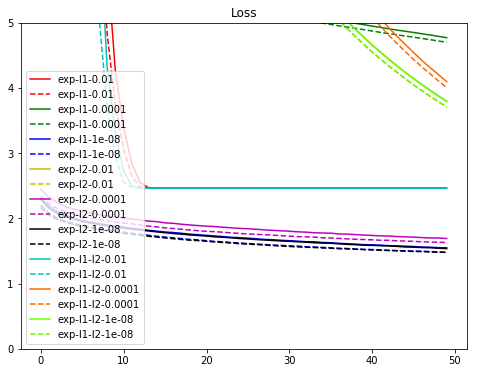

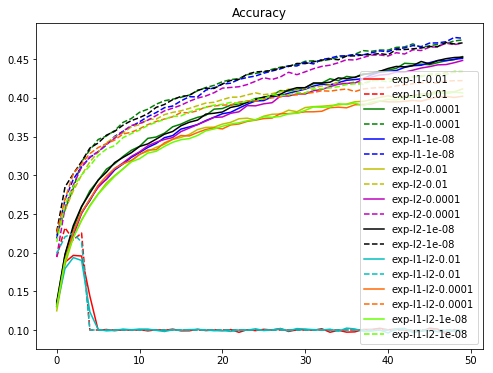

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "c", "#FF6600", "#66FF00"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()